In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as tdist
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.parameter import Parameter

from collections import namedtuple, OrderedDict

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [33]:
from zlib import crc32

theory = crc32('Фельдман'.lower().encode('utf-8'))%3+1
practice = crc32('Feldman'.lower().encode('utf-8'))%3+1
theory, practice

(1, 2)

## 1. Реализуем выбор модели с вариационным нормальным распределением

In [151]:
def prior_std(p):
    stdv = 1
    if p.dim() > 1:
        for i in range(p.dim() - 1):
            stdv = stdv * p.size()[i + 1]
        stdv = 1 / np.sqrt(stdv)
    else:
        stdv = 1e-2
    return stdv

In [73]:
VariationalParameter = namedtuple('VariationalParameter', ['mean', 'rho', 'eps'])
def evaluate_prior_params(variational_parameter):
    return variational_parameter.mean + \
        (1 + variational_parameter.rho.exp()).log() * variational_parameter.eps

def KL_div(parametrs_dict):
    loss = 0
    for p in parametrs_dict.values():
        if isinstance(p, VariationalParameter):
            mean = p.mean
            std = (1 + p.rho.exp()).log()
            std_prior = prior_std(mean)
            loss += (-(std / std_prior).log() +
                     (std.pow(2) + mean.pow(2)) /
                     (2 * std_prior ** 2) - 1 / 2).sum()
        else:
            loss += KL_div(p)
    return loss

def build_params(parameters_dict, module, epsilon_setting):
    for name, p in parameters_dict.items():
        if isinstance(p, VariationalParameter):
            if p.eps is None:
                parameters_dict[name] = p._replace(eps=Variable(p.mean.data.clone()))
            epsilon_setting(name, parameters_dict[name])
            setattr(module, name, evaluate_prior_params(parameters_dict[name]))
        elif p is None:
            setattr(module, name, None)
        else:
            build_params(p, getattr(module, name), epsilon_setting)

In [74]:
class BayessianNeuralNet(nn.Module):
    def __init__(self, model, zero_mean=True, learn_mean=True, learn_rho=True):
        super(BayesanNeuralNetwork, self).__init__()

        self.model = model
        self.diction = OrderedDict()
        self.variationalize(self.diction, self.model, '', zero_mean,
                            learn_mean, learn_rho)
        self.prior_loss = lambda: KL_div(self.diction)

    def variationalize(self, diction, module, prefix, zero_mean,
                       learn_mean, learn_rho):
        to_erase = []
        paras = module._parameters.items()
        for name, p in paras:

            if p is None:
                diction[name] = None
            else:
                stdv = prior_std(p)
                init_rho = np.log(np.exp(stdv) - 1)

                init_mean = p.data.clone()
                if zero_mean:
                    init_mean.fill_(0)

                diction[name] = VariationalParameter(
                    Parameter(init_mean),
                    Parameter(p.data.clone().fill_(init_rho)),
                    None)
                if learn_mean:
                    self.register_parameter(prefix + '_' + name + '_mean', diction[name].mean)
                if learn_rho:
                    self.register_parameter(prefix + '_' + name + '_rho', diction[name].rho)
            to_erase.append(name)

        for name in to_erase:
            delattr(module, name)

        for mname, sub_module in module.named_children():
            sub_diction = OrderedDict()
            self.variationalize(sub_diction, sub_module,
                                prefix + ('_' if prefix else '') +
                                mname, zero_mean,
                                learn_mean, learn_rho)
            diction[mname] = sub_diction

    def forward(self, inputs):
        def get_epsilon_setting(name, p):
            if self.training:
                return p.eps.data.normal_()
            return p.eps.data.zero_()

        build_params(self.diction, self.model, get_epsilon_setting)
        return self.model(inputs)

## 2. Реализуем стандартную сеть

In [170]:
class NeuralNet(nn.Module):
        
    def __init__(self, in_feat=10):
        super(NeuralNet, self).__init__()
        
        layers = []
        layers.append(nn.Linear(in_feat, 25))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(25, 25))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(25, 25))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(25, 1))
        layers.append(nn.LogSigmoid())
        
        self.model  = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

## 3. Сгенерируем данные

Будем рассматривать два класса, в которых данные получены из разных нормальных распределений. Пусть дисперсии в обоих распределениях 1, а матожидания разные: -1 и 1

In [171]:
means = [-2., 2.]
vars = [1., 1.]

In [172]:
class1_train = np.random.normal(means[0], vars[0], 2000)
class2_train = np.random.normal(means[1], vars[1], 2000)
data = (np.r_[class1_train, class2_train]).reshape(2*200, 10)
target = [0]*200 + [1]*200
train_dataset = TensorDataset(torch.Tensor(data), torch.Tensor(target))
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

class1_test = np.random.normal(means[0], vars[0], 1000)
class2_test = np.random.normal(means[1], vars[1], 1000)
data = (np.r_[class1_test, class2_test]).reshape(2*100, 10)
target = [0]*100 + [1]*100
test_dataset = TensorDataset(torch.Tensor(data), torch.Tensor(target))
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

## 4. Инициализируем две модели и проведем эксперименты

In [193]:
reg_model = NeuralNet()
var_model = BayessianNeuralNet(NeuralNet())

In [194]:
def get_acc(test_loader):
    correct = 0
    total = 0
    
    for batch, (data, target) in enumerate(test_loader):
        target = target.float()
        output = (torch.exp(reg_model(data))[:, 0] > .5).float()
        optimizer.zero_grad()

        correct += (output == target).float().sum()
        total += len(output)

    return correct/total

In [195]:
optimizer = optim.Adam(reg_model.parameters(), lr=0.01)

reg_losses = []
reg_acc = []

reg_model.train()

for batch, (data, target) in tqdm(enumerate(train_loader)):
    
    target = target.float()
    output = reg_model(data)
    optimizer.zero_grad()
    
    loss = F.binary_cross_entropy_with_logits(output[:, 0], target)
    loss.backward()
    
    optimizer.step()
    reg_losses.append(float(loss))
    
    with torch.no_grad():
        reg_acc.append(get_acc(test_loader))

40it [00:00, 129.47it/s]


In [196]:
optimizer = optim.Adam(var_model.parameters(), lr=0.01)

var_losses = []
var_acc = []

var_model.train()

for batch, (data, target) in tqdm(enumerate(train_loader)):
    data, target = Variable(data), Variable(target).float()
    output = var_model(data)
    
    optimizer.zero_grad()
    
    loss = F.binary_cross_entropy_with_logits(output[:, 0], target) + var_model.prior_loss()
    loss.backward()
    
    optimizer.step()
    var_losses.append(float(loss))
    
    with torch.no_grad():
        var_acc.append(get_acc(test_loader))

40it [00:00, 100.27it/s]


## 5. Построим графики loss и accuracy

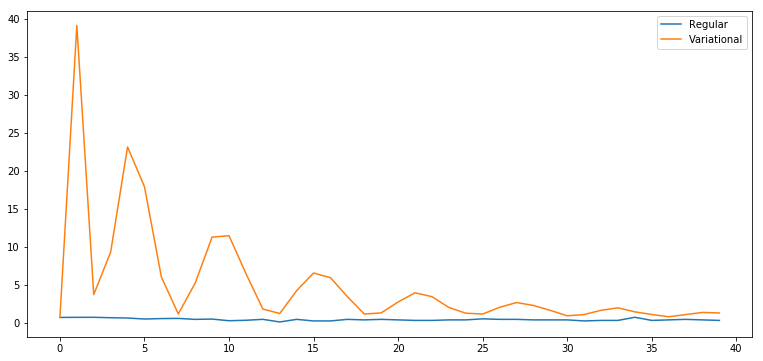

In [197]:
plt.figure(figsize=(13, 6))
plt.plot(reg_losses, label='Regular')
plt.plot(var_losses, label='Variational')
plt.legend()
plt.show()

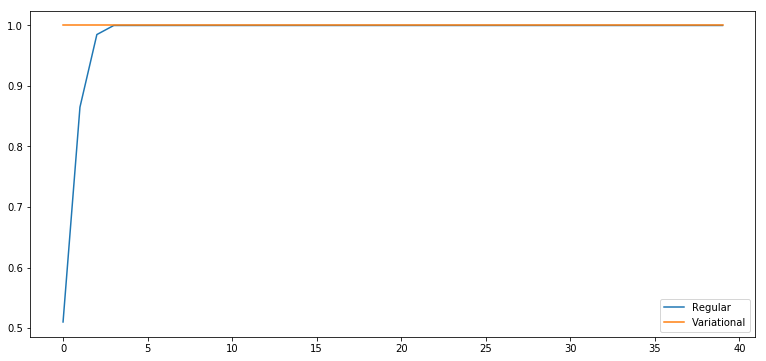

In [198]:
plt.figure(figsize=(13, 6))
plt.plot(reg_acc, label='Regular')
plt.plot(var_acc, label='Variational')
plt.legend(loc='best')
plt.show()

Сразу видно, что при выборе модели с вариационным нормальным расрпдеелением высокая точность достигается буквально за несколько итераций, существенно быстрее, чем для обычной модели